# 文本分类

实施步骤：
+ 解压缩文件，读取每个文件构建可以使用的训练集测试机
+ 训练doc2vec构建模型
+ 对每个文档运行doc2vec 转成向量
+ 构建神经网络分类算法
+ 训练分类，之后调参验证

In [ ]:
from urllib2 import urlopen, URLError, HTTPError
import os
save_path= './'
url = 'http://www.qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz'
f = urlopen(url,timeout=1000)
print "downloading " + url

        # Open our local file for writing
with open(os.path.basename(url), "wb") as local_file:
    local_file.write(f.read())
    print "finish"


In [2]:
data_dir = './'
import helper
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

helper.download_extract(data_dir) #下载并解压文档 同时将文档数据存储到params.p中去 以便于调用

In [3]:
import os
import sys
sentences,collect = helper.read_file() # 将所有文档读入对象并统计每一类个数

print collect
print(sentences['20news-bydate-train'][:2])
print(sentences['20news-bydate-test'][:2])


{'20news-bydate-train': {'rec.motorcycles': 598, 'comp.sys.mac.hardware': 578, 'talk.politics.misc': 465, 'soc.religion.christian': 599, 'comp.graphics': 584, 'sci.med': 594, 'talk.religion.misc': 377, 'comp.windows.x': 593, 'comp.sys.ibm.pc.hardware': 590, 'talk.politics.guns': 546, 'alt.atheism': 480, 'comp.os.ms-windows.misc': 591, 'sci.crypt': 595, 'sci.space': 593, 'misc.forsale': 585, 'rec.sport.hockey': 600, 'rec.sport.baseball': 597, 'sci.electronics': 591, 'rec.autos': 594, 'talk.politics.mideast': 564}, '20news-bydate-test': {'rec.motorcycles': 398, 'comp.sys.mac.hardware': 385, 'talk.politics.misc': 310, 'soc.religion.christian': 398, 'comp.graphics': 389, 'sci.med': 396, 'talk.religion.misc': 251, 'comp.windows.x': 395, 'comp.sys.ibm.pc.hardware': 392, 'talk.politics.guns': 364, 'alt.atheism': 319, 'comp.os.ms-windows.misc': 394, 'sci.crypt': 396, 'sci.space': 394, 'misc.forsale': 390, 'rec.sport.hockey': 399, 'rec.sport.baseball': 397, 'sci.electronics': 393, 'rec.autos': 

# checkpoint 2

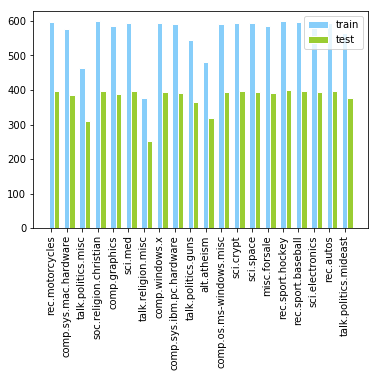

In [6]:
raw_data = helper.load_params() #获取数据集
#print raw_data['20news-bydate-train'][0]
#print raw_data['20news-bydate-test'][0]

# 绘制文档数量柱状图 
X_label = []
Y1 = []
Y2 = []
for i,v in collect['20news-bydate-train'].items():
    X_label.append(i)
    Y1.append(v)
for i,v in collect['20news-bydate-test'].items():   
    Y2.append(v)
X=np.arange(20)
#print X
#print Y1
plt.xticks(X, X_label)
plt.xticks(rotation=90)

plt.bar(X,Y1,width = 0.35,facecolor = 'lightskyblue',edgecolor = 'white',label= 'train')
#width:柱的宽度
plt.bar(X+0.35,Y2,width = 0.35,facecolor = 'yellowgreen',edgecolor = 'white',label= 'test')
plt.legend()

plt.show()

In [8]:
#统计
train_no = len(raw_data['20news-bydate-train'])
test_no = len(raw_data['20news-bydate-test'])
total_news = train_no + test_no
print('训练集共有新闻：%s\n测试集共有新闻：%s\n新闻总数：%s\n '%(train_no,test_no, total_news ))
# 统计每一类
from collections import Counter
total_counts = Counter()
word_total_each = []
for type in raw_data:    
    for news in raw_data[type]:
        i = 0
        for word in news[0].split(" "):
            total_counts[word] += 1  
            i += 1
        word_total_each.append(i)
word_total_each = np.array(word_total_each)
print total_counts.most_common(100) #获取频率最高的单词
print sum(total_counts.values()) #获取单词总数
print len(total_counts) #获取单词种类
print len(word_total_each)
print word_total_each[:10]
print np.median(word_total_each),np.mean(word_total_each),np.std(word_total_each),np.amax(word_total_each),np.amin(word_total_each),np.percentile(word_total_each, 25),np.percentile(word_total_each, 75)
print total_counts.most_common()[:-100:-1] # 获取频率最低的单词

训练集共有新闻：11314
测试集共有新闻：7532
新闻总数：18846
 
[('', 1108085), ('the', 189779), ('to', 106447), ('of', 101735), ('a', 86320), ('and', 78017), ('is', 59439), ('in', 56836), ('that', 51987), ('I', 51813), ('for', 38358), ('you', 30748), ('it', 29526), ('on', 27689), ('be', 26955), ('have', 26314), ('are', 25223), ('with', 24307), ('not', 23166), ('as', 20443), ('this', 20229), ('was', 19001), ('or', 18734), ('From:', 18205), ('The', 16487), ('by', 15347), ('but', 15143), ('at', 14855), ('from', 14519), ('they', 14294), ('an', 13786), ('-', 13624), ('Re:', 12986), ('can', 12924), ('would', 12550), ('will', 12212), ('\n', 12063), ('if', 11872), ('my', 11711), ('about', 11521), ('article', 10797), ('do', 10691), ('has', 10392), ('all', 10160), ('your', 10121), ('one', 9695), ('what', 9623), ('|', 9014), ('we', 9013), ('there', 8811), ('any', 8675), ('who', 8609), ('some', 8302), ('he', 8040), ('were', 7834), ('like', 7810), ('which', 7719), ("don't", 7574), ('out', 7561), ('their', 7526), ('no', 7

### 构建doc2vec

In [9]:
import gensim
import random
from random import shuffle
import datetime
from gensim.models import Doc2Vec

from collections import OrderedDict
from gensim.parsing.preprocessing import STOPWORDS

C:\Users\gcc\Anaconda2\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


第一次错误的实现代码

In [ ]:
'''
import gensim
import random
from random import shuffle
import datetime
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from collections import OrderedDict

LabeledSentence = gensim.models.doc2vec.LabeledSentence
x_train,y_train = helper.labeled_data(raw_data['20news-bydate-train'])
x_test,y_test = helper.labeled_data(raw_data['20news-bydate-test'])

#将news转化为doc2vec model可以处理的对象
def labelizeDoc(doc, label,y):
    labelized = []
    for i,v in enumerate(doc):
        #str1 = ''.join(str(e) for e in y[i])
        tag = '%s_%s_%s'%(label,i,y[i])
        labelized.append(LabeledSentence(v,[tag]))
    return labelized

x_train = labelizeDoc(x_train, 'TRAIN',y_train)
x_test = labelizeDoc(x_test, 'TEST',y_test)
print y_train

%%time


size = 100
min_count = 1
window=10
negative=5
dm=0

#构建两种模型融合的向量
model_dm = gensim.models.Doc2Vec(min_count=min_count, window=window, size=size, sample=1e-3, negative=negative, workers=4)

model_dbow = gensim.models.Doc2Vec(min_count=min_count, window=window, size=size, sample=1e-3, negative=negative, dm=dm, workers=4)
#model_dm = gensim.models.Doc2Vec.load('db.pkl')
#model_dbow = gensim.models.Doc2Vec.load('dm.pkl')
listall = x_train + x_test
l = len(listall)

model_dm.build_vocab(listall)
model_dbow.build_vocab(listall)



model_dm.train(listall,total_examples=model_dm.corpus_count, epochs=20)
model_dbow.train(listall,total_examples=model_dbow.corpus_count, epochs=20)

def getVecs(model, corpus, size):
    vecs = [np.array(model.infer_vector(corpus[z].words)).reshape((1,size)) for z in range(l)]
    return np.concatenate(vecs)



train_vecs_dm = getVecs(model_dm,listall,size)
train_vecs_dbow = getVecs(model_dbow,listall,size)
model_dbow.save('db.pkl')
model_dm.save('dm.pkl')
train_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))

#print listall
#pickle.dump(train_vecs, open('vec.p', 'wb'))
'''

# 正确的代码开始 一种新的方法显示文档转向量

In [10]:
#定义函数将普通文档转换维doc2vec可以接受的 TaggedDocument类
def read_corpus(data,typename,idently):    
    i = 0
    for i, v in enumerate(data):       
        tagname = typename + '_'+str(i)+'_'+ str(idently[i])  
        #不用去除停止词 更准确
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(v[0]), [tagname])         
        #yield gensim.models.doc2vec.TaggedDocument([token for token in gensim.utils.simple_preprocess(v[0]) if token not in STOPWORDS], [tagname])

## 开始训练
根据官方示例 需要多次训练并且每次训练打乱原始数据

In [12]:
# 获取训练集和测试集数据
x_train,y_train = helper.labeled_data(raw_data['20news-bydate-train'])
x_test,y_test = helper.labeled_data(raw_data['20news-bydate-test'])
#因为训练词向量 所以使用所有数据而不是仅仅测试集
x_train += x_test
y_train += y_test

train_corpus = list(read_corpus(x_train, 'TRAIN',y_train))

alpha, min_alpha, passes = (0.025, 0.001, 20)
alpha_delta = (alpha - min_alpha) / passes
#最佳模型采用 PV-DBOW ，size表示最后输出维度，min_count 表示多大重复的字才会被计算到词典中，这里使用2是增加多次出现词的权重
simple_models = [    
    # PV-DM w/concatenation - window=5 (both sides) approximates paper's 10-word total window size
    #Doc2Vec(dm=1, dm_concat=1, size=100, window=5, negative=5, hs=0, min_count=2),
    # PV-DBOW 
    Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2),
    # PV-DM w/average
    #Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2),
]
simple_models[0].build_vocab(train_corpus) # 词典只用建立一次
models_by_name = OrderedDict((str(model), model) for model in simple_models)

print("START %s" % datetime.datetime.now())
for epoch in range(passes):
   
    shuffle(train_corpus)  # shuffling gets best results
    
    for name, train_model in models_by_name.items():
        # train
       
        train_model.alpha, train_model.min_alpha = alpha, alpha  # 随着训练不断减小alpha
        
        # 模型训练 train_model.iter 未定义时默认是5 ，所以20次迭代实际一共训练 5*20= 100 次
        train_model.train(train_corpus, total_examples=train_model.corpus_count, epochs=train_model.iter) 
    
    if ((epoch + 1) % 5) == 0 or epoch == 0: 
        print 'epoch %s finish'%epoch
    alpha -= alpha_delta
    
print("END %s" % str(datetime.datetime.now()))

#储存doc2vec的model
train_model.save('docvec')



START 2017-07-04 07:55:33.710000
epoch 0 finish
epoch 4 finish
epoch 9 finish
epoch 14 finish
epoch 19 finish
END 2017-07-04 08:03:14.993000


使用训练好的模型 把备选类别中的文档转化为向量

In [13]:
#获取这四类新闻的文本和label
x_train,y_train = helper.choiced_data(raw_data['20news-bydate-train'])
x_test,y_test = helper.choiced_data(raw_data['20news-bydate-test'])

#将文本转化为文档向量
x_train_vec = []
x_test_vec = []
for i in x_train:
    # 不去除停止词 
    #inferred_vector = train_model.infer_vector([token for token in gensim.utils.simple_preprocess(i[0]) if token not in STOPWORDS])
    inferred_vector = train_model.infer_vector(gensim.utils.simple_preprocess(i[0])) #这里注意输入必须是数组 而不是文本
    x_train_vec.append(inferred_vector)
for j in x_test:
    #inferred_vector_test = train_model.infer_vector([token for token in gensim.utils.simple_preprocess(j[0]) if token not in STOPWORDS])
    inferred_vector_test = train_model.infer_vector(gensim.utils.simple_preprocess(j[0]))
    x_test_vec.append(inferred_vector_test)

print x_train_vec[0],y_train[0]
print x_test_vec[0],y_test[0]

[-0.29022929 -0.02131885  0.06997196 -0.03630942 -0.15667005 -0.54899549
 -0.40053058  0.06307328 -0.41973639 -0.38301975 -0.10788554  0.0803123
  0.1140438   0.50553316  0.35334292 -0.24127503 -0.51823002 -0.21201651
 -0.93176645 -0.26408252  0.67944497 -0.29362077  0.34222189 -0.4486194
 -0.31743962  0.10339634  0.22640756  0.11830355 -0.40155345  0.05823247
  0.44924802 -0.29592422 -0.15470098  0.87123203  0.1162566   0.41536802
 -0.01487087 -0.09639201 -0.00482817 -0.18357778 -0.14849401  0.5168907
  0.71908361  0.06122489 -0.26806092  0.01820002  0.12464138  0.17566457
  0.17674127 -0.21433148  0.21640746 -0.01086165  0.26427609 -0.10067058
 -0.4354057   0.00342906 -0.14806911  0.03144946 -0.10515675 -0.08119711
  0.19467634 -0.12483282  0.46868122  0.28064594  0.27029836  0.40724874
  0.04654014 -0.76623106  0.3211605   0.20783658 -0.0900288  -0.3979927
 -0.01572291  0.41406542  0.52136225  0.30608132 -0.32545888 -0.37574929
  0.56643945  0.14258274  0.05014882 -0.22649786  0.219

# 分组向量 画图可视化

(2383L, 2L)


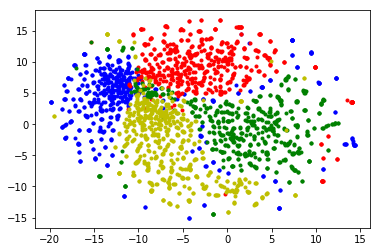

In [14]:
# 不同的类别在图上给予不同的颜色 对四个类别的训练集做展示
from sklearn.manifold import TSNE
ts = TSNE(2)
reduced_vecs = ts.fit_transform(np.concatenate((x_train_vec[:593],x_train_vec[593:1192],x_train_vec[1192:1783],x_train_vec[1783:])))
print reduced_vecs.shape
for i in range(len(reduced_vecs)):
    if i < 593:
        color = 'b'
    elif i>=593 and i<1192:
        color = 'r'
    elif i>=1192 and i<1783:
        color = 'g'
    elif i>=1783:
        color = 'y'
    plt.plot(reduced_vecs[i,0],reduced_vecs[i,1],marker='o',color=color,markersize=3)

# 构建神经网络分类模型

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# 因为算法有设置自动停止 所以步长设置的比较小，迭代次数可以放的多
model =  MLPClassifier(hidden_layer_sizes=(50,25),max_iter=2000,random_state=0,verbose=True,alpha=1,learning_rate_init=0.0001)
scaler = StandardScaler()
scaler.fit(x_train_vec)

# 对得到的向量进行统一的标准化处理
x_train_vec = scaler.transform(x_train_vec)
x_test_vec = scaler.transform(x_test_vec)
#print y_train
model.fit(x_train_vec,y_train)
pp = model.predict(x_test_vec)

from sklearn.metrics import classification_report,confusion_matrix

# 展示一些统计结果 验证准确度
print(confusion_matrix(y_test,pp))
print(classification_report(y_test,pp))


score = model.score(x_test_vec, y_test)
print score

Iteration 1, loss = 1.75931462
Iteration 2, loss = 1.71067396
Iteration 3, loss = 1.66523912
Iteration 4, loss = 1.62268869
Iteration 5, loss = 1.58297124
Iteration 6, loss = 1.54527271
Iteration 7, loss = 1.50926580
Iteration 8, loss = 1.47442451
Iteration 9, loss = 1.44084328
Iteration 10, loss = 1.40758757
Iteration 11, loss = 1.37524672
Iteration 12, loss = 1.34317110
Iteration 13, loss = 1.31117023
Iteration 14, loss = 1.27935257
Iteration 15, loss = 1.24773523
Iteration 16, loss = 1.21589563
Iteration 17, loss = 1.18411751
Iteration 18, loss = 1.15260557
Iteration 19, loss = 1.12104829
Iteration 20, loss = 1.08945780
Iteration 21, loss = 1.05841140
Iteration 22, loss = 1.02735147
Iteration 23, loss = 0.99716459
Iteration 24, loss = 0.96749369
Iteration 25, loss = 0.93854907
Iteration 26, loss = 0.91040445
Iteration 27, loss = 0.88298933
Iteration 28, loss = 0.85651677
Iteration 29, loss = 0.83084344
Iteration 30, loss = 0.80598274
Iteration 31, loss = 0.78210870
Iteration 32, los

# 验证敏感性 
当换取4个类别后使用原model结果再测试一下准确度和可视化

In [16]:
#train_model = Doc2Vec.load('docvec')
classDict = {
                      'soc.religion.christian':1,
                         'talk.politics.guns':2,
                         'talk.politics.mideast':3,
                          'talk.politics.misc':4,
                         
                           }
def choiced_data(params):
    x_train = []
    y_train = []
    for i,v in enumerate(params):  
        if v[1] in ['soc.religion.christian','talk.politics.guns','talk.politics.mideast','talk.politics.misc']:      
            temp = []
            temp.append(v[0])
            x_train.append(temp)
            y_train.append(classDict[v[1]])
    return x_train,y_train


#获取这四类新闻的文本和label
#x_train,y_train = helper.choiced_data(raw_data['20news-bydate-train'])
#x_test,y_test = helper.choiced_data(raw_data['20news-bydate-test'])

#将文本转化为文档向量
x_train_vec = []
x_test_vec = []
for i in x_train:
    #inferred_vector = train_model.infer_vector([token for token in gensim.utils.simple_preprocess(i[0]) if token not in STOPWORDS])
    inferred_vector = train_model.infer_vector(gensim.utils.simple_preprocess(i[0]))
    x_train_vec.append(inferred_vector)
for j in x_test:
    #inferred_vector_test = train_model.infer_vector([token for token in gensim.utils.simple_preprocess(j[0]) if token not in STOPWORDS])
    inferred_vector_test = train_model.infer_vector(gensim.utils.simple_preprocess(j[0]))
    x_test_vec.append(inferred_vector_test)

print x_train_vec[0],y_train[0]
print x_test_vec[0],y_test[0]

[-0.32494515 -0.06328321  0.02822945  0.06484704 -0.25919783 -0.63553035
 -0.07961404  0.2252391  -0.40606835 -0.45290926 -0.21402603 -0.04260479
 -0.11671583  0.73147917  0.23092172 -0.59523886 -0.33662218 -0.21132529
 -0.81809282 -0.53984749  0.54279041 -0.24137831  0.12025501 -0.35299772
 -0.04681556  0.14498094  0.12277087  0.19523869 -0.55623031  0.06881706
  0.4447256  -0.51955068 -0.01358355  0.82180536  0.07460047  0.17427434
 -0.23123425 -0.32603261 -0.10929777 -0.15834786  0.0579363   0.47652623
  0.75795603 -0.30589262 -0.11066277 -0.05224173 -0.00902901  0.08260823
  0.1353993  -0.10714725 -0.06800412  0.16540611  0.1343656  -0.06134597
 -0.44438973  0.25723845 -0.16790456 -0.17233519 -0.14818154  0.01248821
 -0.24315129 -0.15626478  0.43783155  0.2131702   0.19548973  0.35852501
  0.1351763  -0.55242288  0.34799796  0.16616857 -0.05058701 -0.24646167
 -0.08364979  0.42890999  0.35765943  0.31435227 -0.35261714 -0.46567854
  0.45115829  0.22817281  0.13471544 -0.10633718  0

(1585L, 2L)
Iteration 1, loss = 1.76095572
Iteration 2, loss = 1.71241585
Iteration 3, loss = 1.66738088
Iteration 4, loss = 1.62485357
Iteration 5, loss = 1.58543851
Iteration 6, loss = 1.54808160
Iteration 7, loss = 1.51227767
Iteration 8, loss = 1.47782053
Iteration 9, loss = 1.44465072
Iteration 10, loss = 1.41136831
Iteration 11, loss = 1.37923734
Iteration 12, loss = 1.34743425
Iteration 13, loss = 1.31562944
Iteration 14, loss = 1.28413919
Iteration 15, loss = 1.25278460
Iteration 16, loss = 1.22127398
Iteration 17, loss = 1.18958103
Iteration 18, loss = 1.15819942
Iteration 19, loss = 1.12678656
Iteration 20, loss = 1.09545071
Iteration 21, loss = 1.06443999
Iteration 22, loss = 1.03351825
Iteration 23, loss = 1.00310624
Iteration 24, loss = 0.97310019
Iteration 25, loss = 0.94351755
Iteration 26, loss = 0.91489888
Iteration 27, loss = 0.88695484
Iteration 28, loss = 0.85987798
Iteration 29, loss = 0.83371117
Iteration 30, loss = 0.80856384
Iteration 31, loss = 0.78441200
Itera

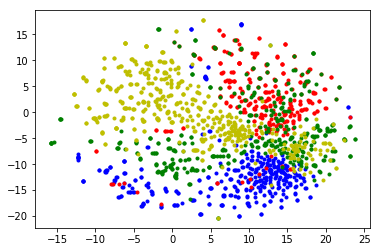

In [17]:
from sklearn.manifold import TSNE
ts = TSNE(2)
reduced_vecs = ts.fit_transform(np.concatenate((x_test_vec[:376],x_test_vec[376:686],x_test_vec[686:1084],x_test_vec[1084:])))
print reduced_vecs.shape
for i in range(len(reduced_vecs)):
    if i < 376:
        color = 'b'
    elif i>=376 and i<686:
        color = 'r'
    elif i>=686 and i<1084:
        color = 'g'
    elif i>=1084:
        color = 'y'
    plt.plot(reduced_vecs[i,0],reduced_vecs[i,1],marker='o',color=color,markersize=3)
    
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# 因为算法有设置自动停止 所以步长设置的比较小，迭代次数可以放的多
model =  MLPClassifier(hidden_layer_sizes=(50,25),max_iter=2000,random_state=0,verbose=True,alpha=1,learning_rate_init=0.0001)
scaler = StandardScaler()
scaler.fit(x_train_vec)

# 对得到的向量进行统一的标准化处理
x_train_vec = scaler.transform(x_train_vec)
x_test_vec = scaler.transform(x_test_vec)
#print y_train
model.fit(x_train_vec,y_train)
pp = model.predict(x_test_vec)

from sklearn.metrics import classification_report,confusion_matrix

# 展示一些统计结果 验证准确度
print(confusion_matrix(y_test,pp))
print(classification_report(y_test,pp))


score = model.score(x_test_vec, y_test)
print score
